In [50]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation    
sns.set(color_codes=True)

pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [7]:
# Load the dataset
data_path = '/Users/kajalshukla/Desktop/MLOPs/Assignments/Assignment-1/adsp_ml_ops/data/athletes.csv'
data = pd.read_csv(data_path)

In [23]:
data.head(3)

,region,gender,age,height,weight,candj,snatch,deadlift,backsq,eat,background,experience,schedule,howlong,total_lift
21,Southern California,Male,30.0,71.0,200.0,235.0,175.0,385.0,315.0,I eat whatever is convenient|,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 1x a week|I ty...,1-2 years|,1110.0
22,Africa,Male,28.0,70.0,176.0,187.0,134.0,335.0,254.0,I eat 1-3 full cheat meals per week|,I have no athletic background besides CrossFit|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 1x a week|,2-4 years|,910.0
27,North East,Male,35.0,68.0,225.0,285.0,205.0,440.0,405.0,I eat quality foods but don't measure the amount|,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I typically rest 4 or more days per month|,2-4 years|,1335.0


# Raw data

## Data Cleaning

In [8]:
## Remove null values of relevant columns
relevant_columns = ['region', 'age', 'weight', 'height', 'howlong', 'gender', 'eat', 'train', 
                    'background', 'experience', 'schedule', 'deadlift', 'candj', 'snatch', 'backsq']
data = data.dropna(subset=relevant_columns)

In [9]:
## Remove irrelevant columns
irrelevant_columns = ['affiliate', 'team', 'name', 'athlete_id', 'fran', 'helen', 'grace',
                      'filthy50', 'fgonebad', 'run400', 'run5k', 'pullups', 'train']
data = data.drop(columns=irrelevant_columns)

In [10]:
## Remove outliers
data = data[data['weight'] < 1500]
data = data[data['gender'] != '--']
data = data[data['age'] >= 18]
data = data[(data['height'] < 96) & (data['height'] > 48)]

data = data[
    (data['deadlift'] > 0) & (data['deadlift'] <= 1105) | 
    ((data['gender'] == 'Female') & (data['deadlift'] <= 636))
]
data = data[(data['candj'] > 0) & (data['candj'] <= 395)]
data = data[(data['snatch'] > 0) & (data['snatch'] <= 496)]
data = data[(data['backsq'] > 0) & (data['backsq'] <= 1069)]

In [ ]:
data.head(5)

In [11]:
## Clean survey data
decline_dict = {'Decline to answer|': np.nan}
data = data.replace(decline_dict)
data = data.dropna(subset=['background', 'experience', 'schedule', 'howlong', 'eat'])


In [12]:
data.head(5)

,region,gender,age,height,weight,candj,snatch,deadlift,backsq,eat,background,experience,schedule,howlong
21,Southern California,Male,30.0,71.0,200.0,235.0,175.0,385.0,315.0,I eat whatever is convenient|,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 1x a week|I ty...,1-2 years|
22,Africa,Male,28.0,70.0,176.0,187.0,134.0,335.0,254.0,I eat 1-3 full cheat meals per week|,I have no athletic background besides CrossFit|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 1x a week|,2-4 years|
27,North East,Male,35.0,68.0,225.0,285.0,205.0,440.0,405.0,I eat quality foods but don't measure the amount|,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I typically rest 4 or more days per month|,2-4 years|
50,North Central,Male,36.0,71.0,199.0,267.0,212.0,485.0,390.0,I eat quality foods but don't measure the amount|,I played youth or high school level sports|I p...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 3+ times a wee...,1-2 years|
60,North East,Male,36.0,64.0,155.0,245.0,180.0,415.0,385.0,I eat strict Paleo|,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 2x a week|I st...,4+ years|


### Determine the highest variability in columns to calculate total_lift

In [13]:
#Calculate standard deviation
numeric_columns = ['age', 'weight', 'height', 'howlong', 'deadlift', 'candj', 'snatch', 'backsq']

data_v1_std_devs = data[numeric_columns].std()

#Sort columns by their standard devation
sorted_columns_v1 = data_v1_std_devs.sort_values(ascending=False).index.tolist()

/var/folders/dn/9qflv0c57rl7ynhwt9tnqmrr0000gn/T/ipykernel_26198/2011793858.py:4: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_v1_std_devs = data[numeric_columns].std()


In [14]:
print(sorted_columns_v1)

['deadlift', 'backsq', 'candj', 'snatch', 'weight', 'age', 'height']


### The highest variability to calculate total_lift is 'deadlift', 'backsq', 'candj'

In [15]:
data['total_lift'] = data['deadlift'] + data['candj'] + data['snatch'] + data['backsq']


## EDA

In [25]:
data.dtypes

region         object
gender         object
age           float64
height        float64
weight        float64
candj         float64
snatch        float64
deadlift      float64
backsq        float64
eat            object
background     object
experience     object
schedule       object
howlong        object
total_lift    float64
dtype: object

In [26]:
data.shape

(30029, 15)

In [27]:
data.count()

region        30029
gender        30029
age           30029
height        30029
weight        30029
candj         30029
snatch        30029
deadlift      30029
backsq        30029
eat           30029
background    30029
experience    30029
schedule      30029
howlong       30029
total_lift    30029
dtype: int64

In [28]:
data = data.drop_duplicates()
print(data.isnull().sum())

region        0
gender        0
age           0
height        0
weight        0
candj         0
snatch        0
deadlift      0
backsq        0
eat           0
background    0
experience    0
schedule      0
howlong       0
total_lift    0
dtype: int64


In [29]:
data.describe()

,age,height,weight,candj,snatch,deadlift,backsq,total_lift
count,30028.000000,30028.000000,30028.000000,30028.000000,30028.000000,30028.000000,30028.000000,30028.000000
mean,32.123718,68.871620,177.128513,205.417077,156.172905,361.932563,294.117124,1017.639670
std,7.435515,3.774632,32.398336,58.688040,48.833871,96.746733,85.082250,277.685737
min,18.000000,52.000000,5.000000,1.000000,1.000000,0.000000,1.000000,4.000000
25%,27.000000,66.000000,155.000000,160.000000,120.000000,287.000000,225.000000,805.000000
50%,31.000000,69.000000,178.000000,205.000000,155.000000,375.000000,300.000000,1040.000000
75%,37.000000,72.000000,197.000000,245.000000,190.000000,434.250000,355.000000,1224.000000
max,56.000000,83.000000,474.000000,390.000000,386.000000,1000.000000,882.000000,2135.000000


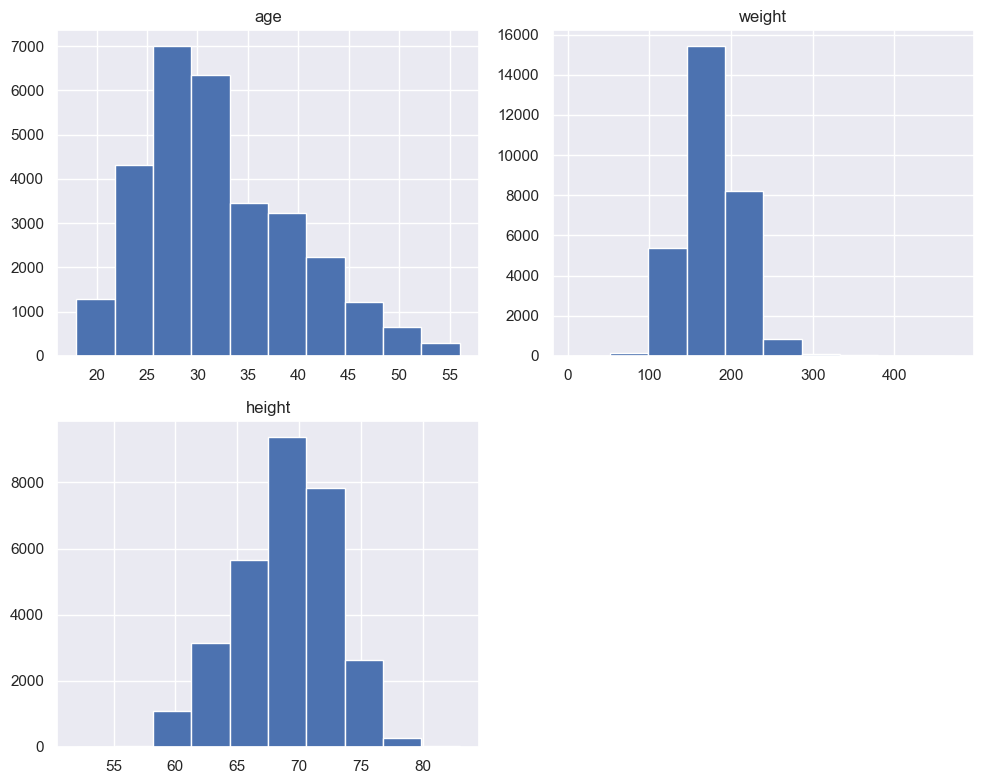

In [30]:
#Histogram for age, weight and height
data[['age', 'weight', 'height']].hist(figsize=(10,8))
plt.tight_layout()
plt.show()

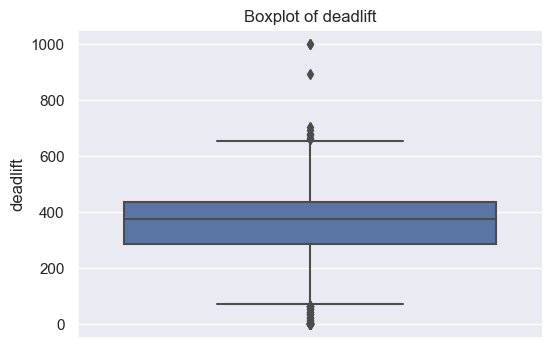

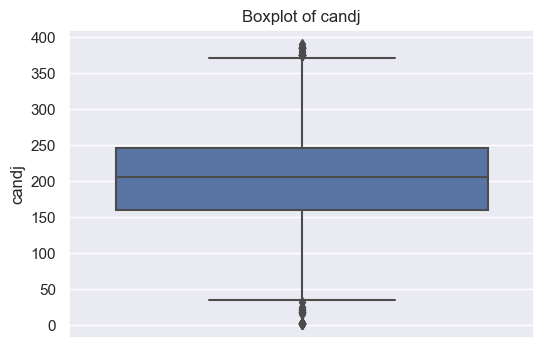

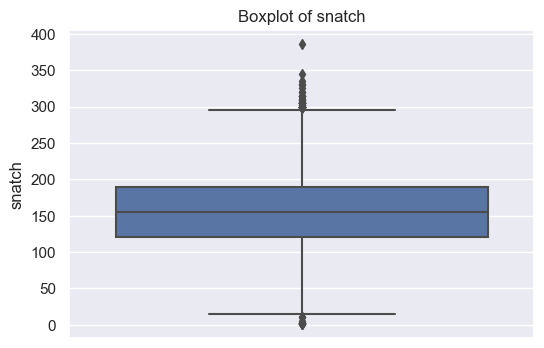

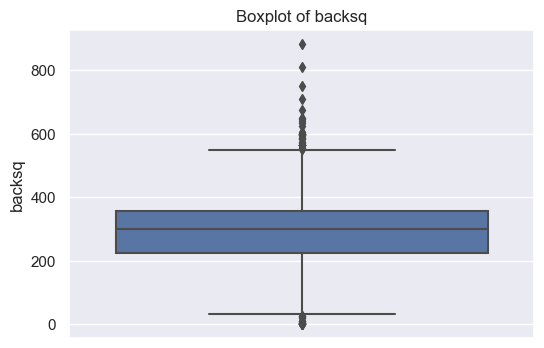

In [31]:
#Boxplot for numeric lifting columns
lift_columns_v1 = ['deadlift', 'candj', 'snatch', 'backsq']
for col in lift_columns_v1:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

Text(0.5, 0, 'Gender(0:male, 1:female)')

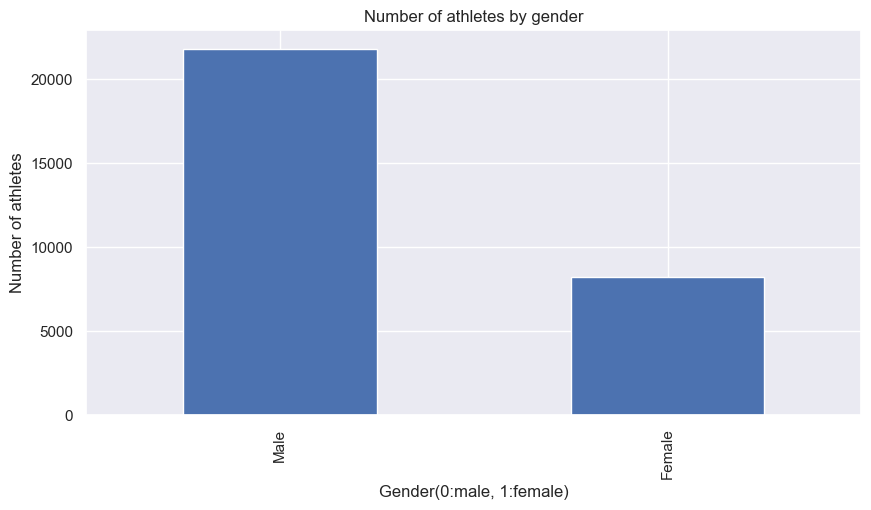

In [35]:
# gender counts
data["gender"].value_counts().plot(kind='bar', figsize=(10,5))
plt.title("Number of athletes by gender")
plt.ylabel('Number of athletes')
plt.xlabel('Gender(0:male, 1:female)')

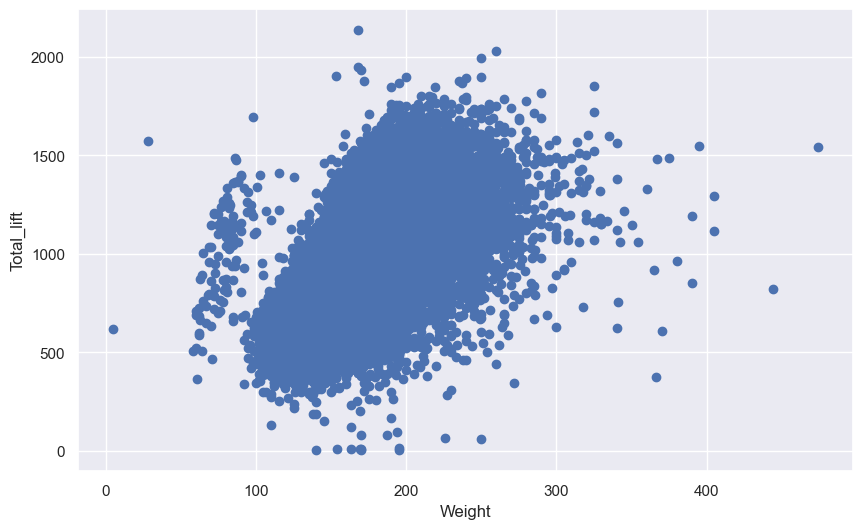

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(data["weight"], data['total_lift'])
ax.set_xlabel('Weight')
ax.set_ylabel('Total_lift')
plt.show()

## Dealing with Categorical Values

In [43]:
# One-Hot Encoding for categorical columns
categorical_cols = ['region', 'gender', 'eat', 'background', 'experience', 'schedule', 'howlong']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [44]:
# Convert float columns to int
float_cols = ['age', 'height', 'weight', 'candj', 'snatch', 'deadlift', 'backsq', 'total_lift']
for col in float_cols:
    data[col] = data[col].astype(int)

In [46]:
# Verify the changes
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns

data.dtypes

age                                                                                                                                                                                                                                                                                                                           int64
height                                                                                                                                                                                                                                                                                                                        int64
weight                                                                                                                                                                                                                                                                                                                        int64
candj                       

## Model

In [47]:
#Split data for data_v1
X_v1  = data.drop('total_lift', axis=1)
y_v1 = data['total_lift']
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(X_v1, y_v1, test_size=0.2, random_state=42) 


In [48]:
# Baseline model on data version 1
model_v1 = LinearRegression()

In [49]:
model_v1.fit(X_train_v1, y_train_v1)

LinearRegression()

In [51]:
# Make predictions
y_pred_v1 = model_v1.predict(X_test_v1)

In [52]:
# Evaluate the model
mse = mean_squared_error(y_test_v1, y_pred_v1)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 1.0625855414928105e-25


In [53]:
r2 = r2_score(y_test_v1, y_pred_v1)
print(f'R-squared: {r2}')

R-squared: 1.0
